# Modern Portfolio Theory (MPT)

Modern Portfolio Theory (MPT), developed by economist Harry Markowitz in the 1950s, is a framework for constructing investment portfolios that aim to maximize expected returns for a given level of risk or minimize the level of risk for a given expected return. 
MPT revolutionized the way investors think about diversification and risk management. 
Modern Portfolio Theory has had a profound impact on investment strategy and asset allocation, providing a systematic approach to balancing risk and return in investment portfolios. 

In this notebook we will be implementing the portfolio optimization from scratch and then use some packages to automate it. Later we will also look at different volatility calculations and how it affects the results.

## Equally-weighted portfolio

In [1]:
import yfinance as yf
import pandas_datareader.data as pdr
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import quantstats as qs

yf.pdr_override()

# Define a list of stock symbols belonging to tech sectors

stock_symbols = ["META", "TSLA", "X", "MSFT"]

# start date
start_date = '2018-01-01'
# end date
end_date = '2023-01-01'

# Fetch stock data along with sector information
prices_df = pdr.get_data_yahoo(stock_symbols,start_date,end_date)['Adj Close']


# assign equal weights to all assets
weights = np.array(len(stock_symbols) * [1 / len(stock_symbols)])


# returns
returns = prices_df.pct_change()
returns.dropna(inplace=True)


# portfolio returns into a dataframe
portfolio_returns = pd.Series(np.dot(returns,weights.T),index=returns.index)

[*********************100%%**********************]  4 of 4 completed


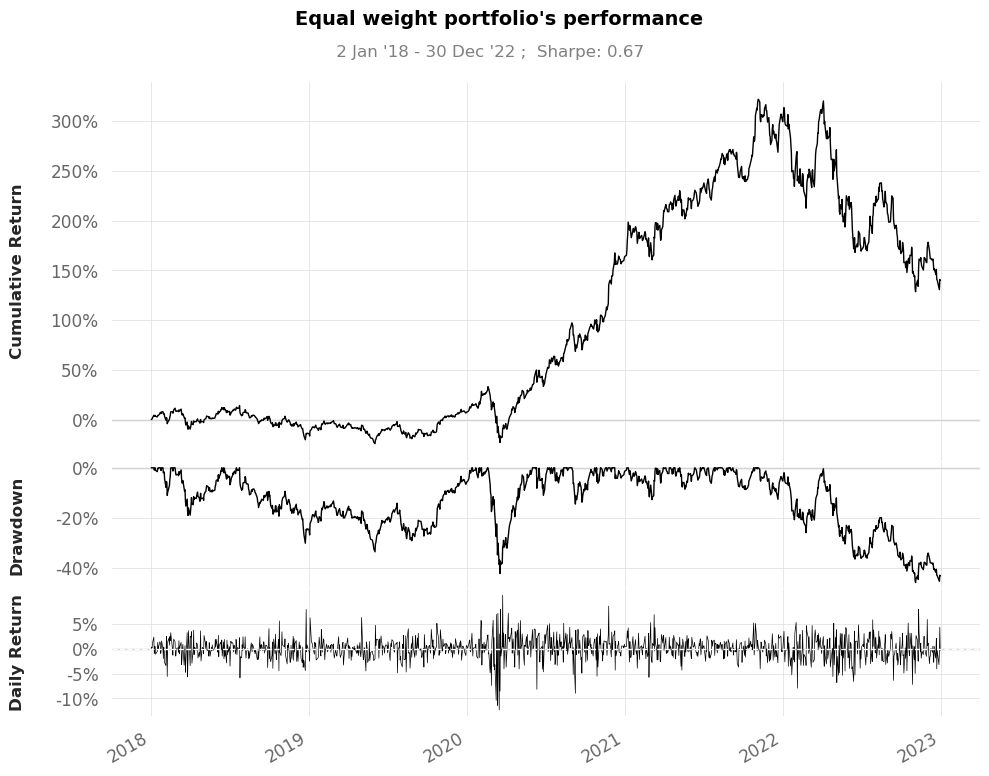

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# plot the portfolio performance
qs.plots.snapshot(portfolio_returns,title="Equal weight portfolio's performance",
grayscale=True)

plt.show()

A drawdown refers to the peak-to-trough decline in the value of an investment or a trading account, typically expressed as a percentage. It represents the largest loss an investor or fund experiences before a new peak is reached. 

In [3]:
# get the metric for the portfolio using bechmark SPY which follows S&P500
# for more detailed discussion on the metric, please refer to Portfolio_analysis.ipynb

qs.reports.metrics(portfolio_returns,benchmark="SPY",mode="basic",prepare_returns=False)


[*********************100%%**********************]  1 of 1 completed
                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2018-01-03         2018-01-03
End Period          2022-12-30         2022-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   41.39%             139.13%
CAGR﹪              4.91%              12.82%

Sharpe              0.43               0.66
Prob. Sharpe Ratio  82.94%             93.0%
Sortino             0.59               0.94
Sortino/√2          0.42               0.67
Omega               1.12               1.12

Max Drawdown        -34.1%             -45.84%
Longest DD Days     361                534

Gain/Pain Ratio     0.09               0.12
Gain/Pain (1M)      0.43               0.63

Payoff Ratio        0.89               0.92
Profit Factor       1.09               1.12
Common Sense Ratio  0.92               1.12
CPC Index      

Portfolio variance is defined as:

$\sigma_{port}^2 = weights^{T} \cdot Cov_{port} \cdot weights$

where $Cov_{port}$ is the covariance matrix of the portfolio and $weights$ is the vector of weights for each asset. 

In [5]:
# variance matrix 
var_yr = returns.cov() * 252

print(var_yr.shape,weights.T.shape,np.transpose(weights).shape)
# portfolio variance
port_var = weights.T@var_yr@weights

# portfolio volatility
port_vol = np.sqrt(port_var)

print(port_var, port_vol)

(4, 4) (4,) (4,)
0.13078861835379163 0.36164709089634833


In Modern Portfolio Theory (MPT), the goal is typically to either maximize the expected portfolio return for a given level of risk or minimize the portfolio risk for a given level of expected return. The optimization problem involves finding the weights of each asset in the portfolio that achieve these objectives. Here are the general formulas for the optimization problems in MPT:

<u>Maximizing Expected Portfolio Return for a Given Level of Risk</u>:

Objective:
$ \text{Maximize} \quad \text{Expected Portfolio Return} = \sum_{i=1}^{n} w_i \cdot \text{Expected Return}_i $

Subject to:
$ \sum_{i=1}^{n} w_i = 1 $
$ \text{Portfolio Variance} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \text{Covariance}_{ij} \leq \text{Target Risk} $

Where:
- $ n $ is the number of assets in the portfolio.
- $ w_i $ is the weight of asset $ i $ in the portfolio.
- $ \text{Expected Return}_i $ is the expected return of asset $ i $.
- $ \text{Covariance}_{ij} $ is the covariance between the returns of assets $ i $ and $ j $.
- The constraint $ \sum_{i=1}^{n} w_i = 1 $ ensures that the weights sum up to 1.

<u>Minimizing Portfolio Risk for a Given Level of Expected Return</u>:

Objective:
$ \text{Minimize} \quad \text{Portfolio Variance} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \text{Covariance}_{ij} $

Subject to:
$ \sum_{i=1}^{n} w_i \cdot \text{Expected Return}_i \geq \text{Target Expected Return} $
$ \sum_{i=1}^{n} w_i = 1 $

Where:
- $ \text{Target Expected Return} $ is the desired level of expected return for the portfolio.

These optimization problems are typically solved using mathematical optimization techniques. The solutions will give you the set of portfolio weights that achieve the specified objectives.

## Efficient Frontier Using Monte Carlo

The efficient frontier is a set of optimal portfolios in the 
risk-return spectrum.

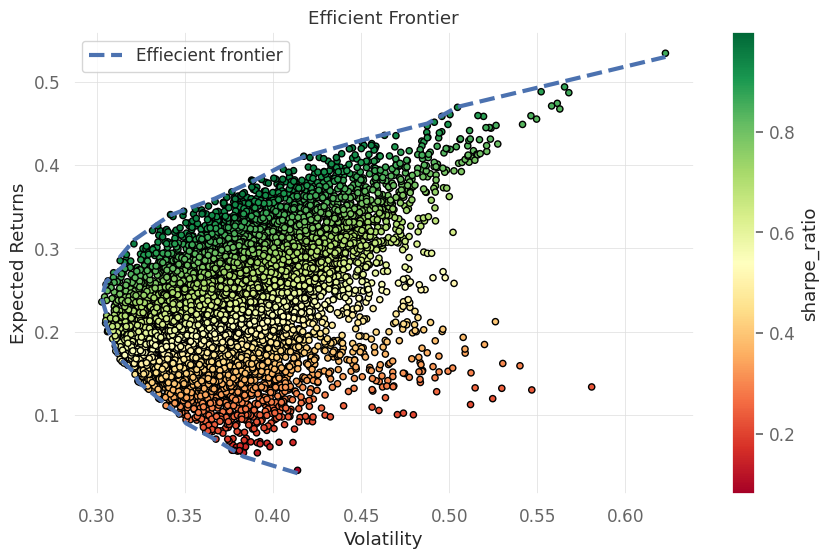

In [6]:
# Efficient frontier
import pandas as pd 


mean_returns = returns.mean()
cov_matrix = returns.cov()
# Number of portfolios to simulate
nsim = 10000
# Risk free rate 
risk_free_rate = 0.018

mean_returns = returns.mean() * 252
covariance_matrix = returns.cov() * 252

# generate random portfolio weights
np.random.seed(42)
weights = np.random.random(size=(nsim, len(stock_symbols)))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]


port_retn = np.dot(weights, mean_returns)
port_vol = []
port_weights = []
# run simulation
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(covariance_matrix, weights[i]))
    )
    port_vol.append(vol)
    port_weights.append(weights[i])

# make an array
portf_vol = np.array(port_vol)

# get sharpe ratio
portf_sharpe_ratio = port_retn / portf_vol


# results df
results_df = pd.DataFrame(
    {"returns": port_retn,
    "volatility": portf_vol,
    "sharpe_ratio": portf_sharpe_ratio}
)

port_df = pd.DataFrame(port_weights,index=results_df.index,columns=stock_symbols)


# get maximum sharpe ratio
idx_maxsharpe = results_df["sharpe_ratio"].idxmax()
df_max_sharpe = results_df.iloc[idx_maxsharpe]
weight_max_sharpe = port_df.iloc[idx_maxsharpe]

# get minimum volatility
idx_minvol = results_df["volatility"].idxmin()
df_min_vol = results_df.iloc[idx_minvol]
weight_min_vol = port_df.iloc[idx_minvol]

npoints = 30
ef_rtn_list = []
ef_vol_list = []

# get range of returns
ef_retns = np.linspace(results_df["returns"].min(),results_df["returns"].max(),npoints)
# round the values
ef_retns = np.round(ef_retns, 2)

# actual returns
portf_rtns = np.round(port_retn, 2)

# for every return value find a minimum volatility
for rtn in ef_retns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))


# plot the results
fig, ax = plt.subplots()
results_df.plot(kind="scatter", x="volatility",
                    y="returns", c="sharpe_ratio",
                    cmap="RdYlGn", edgecolors="black",
                    ax=ax)

ax.set(xlabel="Volatility",ylabel="Expected Returns",title="Efficient Frontier")


ax.plot(ef_vol_list, ef_rtn_list, "b--",linewidth=3,label='Effiecient frontier')


ax.legend()
plt.show()

In [7]:
print("At maximum Sharpe Ratio\n")
print(f"Return:{df_max_sharpe['returns']}")
print(f"Volatility: {df_max_sharpe['volatility']}")
print(f"Portfolio: {weight_max_sharpe.to_dict()}")
print(f"Sharpe ratio: {df_max_sharpe['sharpe_ratio']}")
print("\n")
print("At Minimum risk\n")
print(f"Return:{df_min_vol['returns']}")
print(f"Volatility: {df_min_vol['volatility']}")
print(f"Portfolio: {weight_min_vol.to_dict()}")
print(f"Sharpe ratio: {df_min_vol['sharpe_ratio']}")
print("\n")

At maximum Sharpe Ratio

Return:0.34062078416847674
Volatility: 0.34168156067574446
Portfolio: {'META': 0.00021933368698373237, 'TSLA': 0.7269567018473118, 'X': 0.2574952867649712, 'MSFT': 0.015328677700733293}
Sharpe ratio: 0.996895423606794


At Minimum risk

Return:0.2357896874186083
Volatility: 0.3026424789381148
Portfolio: {'META': 0.0917403347472675, 'TSLA': 0.7961297432004478, 'X': 0.021304457291594758, 'MSFT': 0.09082546476068984}
Sharpe ratio: 0.7791030797987326




## Efficient frontier using Scipy

In order to find the portfolio that gives highest returns for a given risk (volatility) or lowest risk (volatility) for a given return we can utilise numerical optimization. Optimization gives the best value of a function subjected to some boundary contraints affecting the target variable.

In the case of porfolio optimization we can express the equations as:

$ min (\omega^T \Sigma \omega)$

with constraints:

\begin{align*}
\omega^T \bold{I}=& b\\
\omega \geq& 0\\
\omega^{T}\mu =& \mu_p
\end{align*}

here $\omega$ is the weight vector, $\Sigma$ is the covariance matrix, $\mu$ is the vector of returns with $\mu_p$ is the expected portfolio return.

For a range of expected returns we find the optimal weights


### Minimum risk 

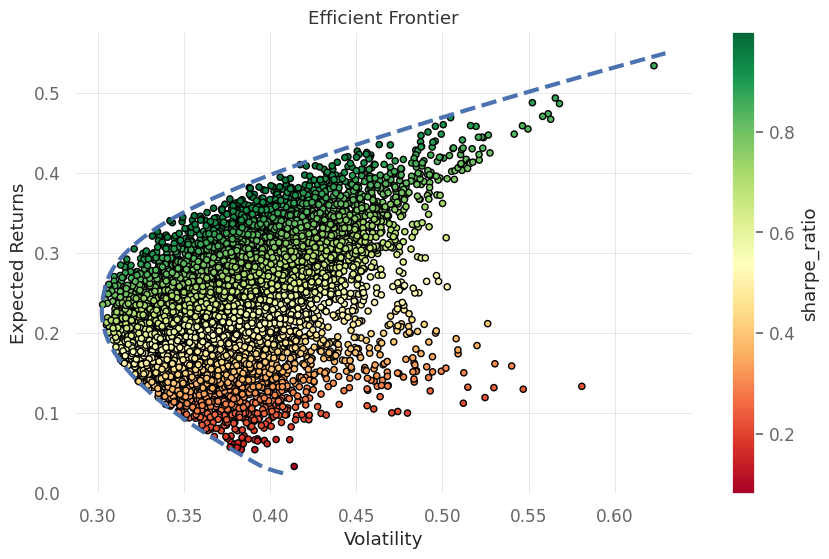

In [8]:
import numpy as np
import scipy.optimize as sco

# function to calculate portfolio return.
def portfolio_return(weights, asset_returns):
    return np.dot(weights, asset_returns)

# function to calculate portfolio volatility.
def portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# function to efficient portfolios along the efficient frontier.
def Efficient_frontier(asset_returns, covariance_matrix, target_returns):
    """
    Parameters:
    - asset_returns (array): Array of average returns for each asset.
    - covariance_matrix (array): Covariance matrix of asset returns.
    - target_returns (array): Array of target returns for which efficient portfolios are generated.
    """
    efficient_portfolios = []

    # Number of assets
    n_assets = len(asset_returns)

    # Define bounds for weights (between 0 and 1)
    bounds = tuple((0, 1) for _ in range(n_assets))

    # Initial guess for weights (equally weighted)
    weights0 = n_assets * [1. / n_assets, ]

    # Loop through target returns and find corresponding efficient portfolios
    for target_return in target_returns:
        # Constraints for optimization
        constraints = (
            {"type": "eq", "fun": lambda weights: portfolio_return(weights, asset_returns) - target_return},
            {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
        )

        # Optimize for minimum volatility
        result = sco.minimize(
            portfolio_volatility,
            weights0,
            args=(covariance_matrix,),
            method="SLSQP",
            constraints=constraints,
            bounds=bounds
        )

        # Save information about the efficient portfolio
        efficient_portfolios.append({
            'Return': target_return,
            'Volatility': result.fun,
            'Weights': result.x.tolist()
        })

    return efficient_portfolios


# define returns range
returns_range = np.linspace(0.025, 0.55, 400)

# covariance matrix
covariance_matrix = returns.cov() * 252

# asset returns
asset_returns = returns.mean() * 252

# run efficient frontier optimization
efficient_portfolios = Efficient_frontier(asset_returns, covariance_matrix, returns_range)

# volatility range
volatility_range = [p['Volatility'] for p in efficient_portfolios]


# plot efficient frontier

fig, ax = plt.subplots()

results_df.plot(kind="scatter", x="volatility",y="returns", c="sharpe_ratio",cmap="RdYlGn", edgecolors="black",ax=ax)

ax.plot(volatility_range, returns_range, "b--", linewidth=3)
ax.set(xlabel="Volatility",ylabel="Expected Returns",title="Efficient Frontier")
plt.show()


In [9]:
min_vol_ind = np.argmin(volatility_range)
min_vol_portf_rtn = returns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]["Volatility"]
min_vol_weights = efficient_portfolios[min_vol_ind]["Weights"]

min_vol_weights = dict(zip(stock_symbols, min_vol_weights))

print("At Minimum risk\n")
print(f"Return: {min_vol_portf_rtn}")

print(f"Volatility: {min_vol_portf_vol}")
print(f"Sharpe Ratio: {min_vol_portf_rtn / min_vol_portf_vol}")
print(f"weights: {min_vol_weights}")
print(f"Sharpe Ratio: {(min_vol_portf_rtn / min_vol_portf_vol)}")


At Minimum risk

Return: 0.2276315789473684
Volatility: 0.30210659990319516
Sharpe Ratio: 0.7534809865799325
weights: {'META': 0.0937157693026046, 'TSLA': 0.8067261730061059, 'X': 0.0, 'MSFT': 0.09955805769128928}
Sharpe Ratio: 0.7534809865799325


The minimum volatility portfolio is achieved by investing mostly in TESLA, Meta and Microsoft while not 
investing in X at all.

### Maximum Sharpe Ratio



In [10]:

# define negative sharpe ratio for a optimization
def neg_sharpe(weight, avg_rtns, covariance_matrix, risk_free_rate):
    # calculate portfolio return and volatility
    port_ret = np.sum(avg_rtns * weight)
    port_vol = np.sqrt(np.dot(weight.T, np.dot(covariance_matrix, weight)))

    # get sharpe ratio
    port_sr = (
        (port_ret - risk_free_rate) / port_vol)
    
    return -port_sr

# we are searching for the portfolio with maximum sharpe ratio so we need to optimize for negative sharpe ratio

average_returns = returns.mean() * 252
covariance_matrix = returns.cov() * 252
# assume zero risk free rate
risk_free_rate = 0.


args = (average_returns,covariance_matrix,risk_free_rate)

# contraints
constraints = (
    {
        "type": "eq",
        "fun": lambda x: np.sum(x) - 1
    }
)

# bounds for weights
bounds = tuple((0, 1) for stock in range(len(stock_symbols)))

# initial guess
weight0 = np.array(len(stock_symbols) * [1. / len(stock_symbols)])

# minimize the function

max_sharpe = sco.minimize(neg_sharpe,
                                x0=weight0,
                                args=args,
                                method="SLSQP",
                                bounds=bounds,
                                constraints=constraints)

# make dictionary containing results
max_sharpe_port = {

    "returns": portfolio_return(max_sharpe.x,average_returns),
    "volatility": portfolio_volatility(max_sharpe.x,covariance_matrix),
    "sharpe_ratio": -max_sharpe.fun,
    "weights": max_sharpe.x.tolist()

}

# get weights df
max_sharpe_weights = dict(zip(stock_symbols, max_sharpe_port["weights"]))

print("At maximum sharpe ratio\n")
print(f"Return: {max_sharpe_port['returns']}")
print(f"Volatility: {max_sharpe_port['volatility']}")
print(f"Sharpe Ratio: {max_sharpe_port['sharpe_ratio']}")
print(f"weights: {max_sharpe_weights}")


At maximum sharpe ratio

Return: 0.3632417567223674
Volatility: 0.3612470733167341
Sharpe Ratio: 1.0055216596976673
weights: {'META': 0.0, 'TSLA': 0.6746528482243279, 'X': 0.32534715177567214, 'MSFT': 0.0}


The analysis indicates that most weight should be in TESLA and X with no allocation to META and Microsoft

### Efficient frontier using convex optimization

Instead of optimizing the portfolio using mean-variance we can pose the problem in risk-adjusted retrun maximization.
The problem then becomes:


\begin{align*}
max( \omega^T\mu -& \gamma \omega^T \Sigma \omega)\\
\omega^T\bold{I} =& 1 \\
\omega \geq& 0
\end{align*}

Here, $\gamma \in [0,\infty)$ is risk aversion parameter. Higher value suggest more risk aversion.

This problem can now be solved using convex optimization which is easier to solve. 

Key characteristics of convex optimization include:

- Objective Function Convexity:The objective function to be minimized (or maximized) is convex. A function is convex if, for any two points in its domain, the line segment connecting these two points lies above the graph of the function.
- Convex Constraints: If there are inequality constraints, they must also be convex. For example, a convex constraint is one where the feasible region is a convex set.

- Unique Global Minimum: Convex optimization problems have the property that any local minimum is also a global minimum. This simplifies the search for the optimal solution.

- Efficient Algorithms: Convex optimization problems have efficient algorithms for finding the global minimum. Some well-known algorithms include the interior-point methods and gradient descent.

In [11]:
import cvxpy as cp

# setup the cvxpy variables
weights = cp.Variable(len(stock_symbols))

# risk aversion factor
gamma_para = cp.Parameter(nonneg=True)

# portfolio return
port_ret_cvx = mean_returns.values@weights

# portfolio volatility
port_vol_cvx = cp.quad_form(weights, covariance_matrix.values)

# define function
obj_fun = cp.Maximize(port_ret_cvx - gamma_para * port_vol_cvx)

# define problem and add constraints
prob = cp.Problem(obj_fun,[cp.sum(weights) == 1, weights >= 0])



In [12]:
# place holder for portfolio return, volatility and weights
port_ret_cvx_ef = []
port_vol_cvx_ef = []
weights_ef = []

# define gamma range
gamma_range = np.logspace(-3, 3, num=25)

# loop through gamma
for gamma in gamma_range:
    # set value of gamma
    gamma_para.value = gamma
    # solve problem
    prob.solve()
    # get portfolio return
    port_vol_cvx_ef.append(cp.sqrt(port_vol_cvx).value)
    # get portfolio volatility
    port_ret_cvx_ef.append(port_ret_cvx.value)
    # get portfolio weights
    weights_ef.append(weights.value)


# create dataframe for weights

weights_df = pd.DataFrame(weights_ef, index=np.round(gamma_range,3),columns=stock_symbols)


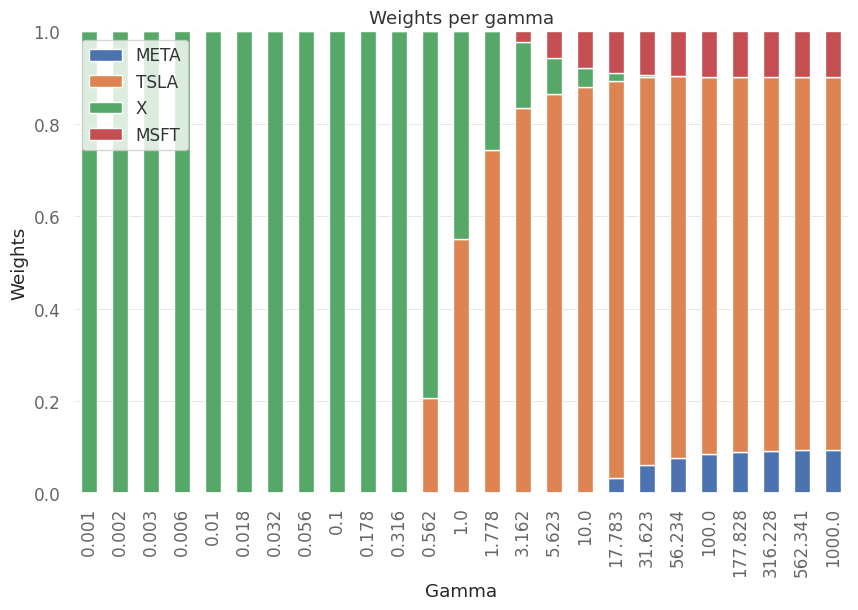

In [13]:
# plot the weight allocation for different gamma

fig,ax = plt.subplots(1,1)

weights_df.plot(kind='bar',ax=ax,stacked=True,title="Weights per gamma",xlabel="Gamma",ylabel="Weights")

plt.show()

For low risk aversion the allocation is 100% to X but as the risk aversion increases the majority of allocation is in TESLA.

<Axes: xlabel='volatility', ylabel='returns'>

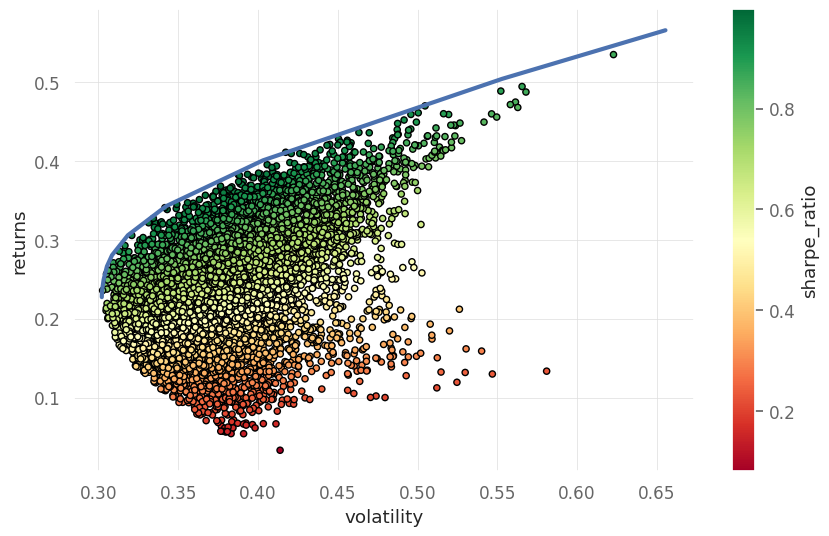

In [14]:
# plot efficient frontier
fig,ax = plt.subplots(1,1)
ax.plot(port_vol_cvx_ef, port_ret_cvx_ef, "b-", linewidth=3)

results_df.plot(kind="scatter", x="volatility",y="returns", c="sharpe_ratio",cmap="RdYlGn", edgecolors="black",ax=ax)

**Maximum allowed Leverage**


The maximum allowable leverage in portfolio optimization refers to the highest level of borrowed funds or debt that an investor can use to invest in a portfolio. 
Leverage is often expressed as a ratio of the total value of the investment to the investor's own capital. 
For example, a leverage ratio of 2:1 means that for every $1 of the investor's own capital, they can borrow an additional $2.

In the context of portfolio optimization, the maximum allowable leverage is a critical parameter as it determines the risk and potential return of the portfolio. 
Higher leverage allows investors to amplify both gains and losses.

We can incorporate maximum allowed leverage into the analysis done above by restricting the norm of weight vector to maximum leverage.

In [15]:
# define maximum leverage parameter
max_leverage = cp.Parameter()

# define problem with leverage
prob_with_l = cp.Problem(obj_fun, 
    [cp.sum(weights) == 1, 
    cp.norm(weights, 1) <= max_leverage])


# range of leverage
lev_range = [1,3,5]

N = len(gamma_range)
# place holder for portfolio return, volatility and weights
portfolio_return = np.zeros((N,len(lev_range)))
portfolio_volatility = np.zeros((N,len(lev_range)))
portfolio_weights = np.zeros((len(lev_range),N,len(stock_symbols)))



In [16]:
# loop through leverage and gamma
# record the results in the placeholders

for l,lev in enumerate(lev_range):
    for g in range(N):
        # set values of variables
        max_leverage.value = lev
        gamma_para.value = gamma_range[g]
        # solve the equations
        prob_with_l.solve()
        # fill the values in place holders
        portfolio_return[g,l] = port_ret_cvx.value
        portfolio_volatility[g,l] = cp.sqrt(port_vol_cvx).value
        portfolio_weights[l,g,:] = weights.value


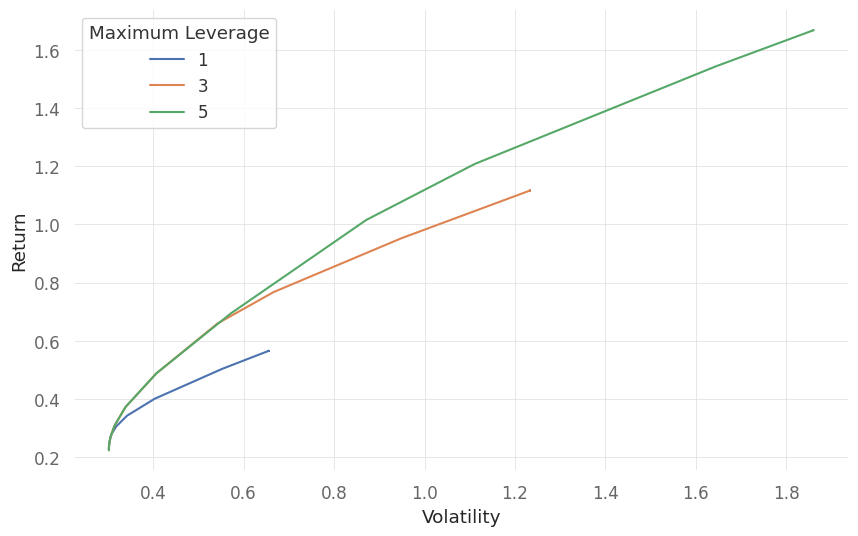

In [17]:
# plot the weights for different gamma

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Volatility')
ax.set_ylabel(r'Return')

for k,lev in enumerate(lev_range):
    ax.plot(portfolio_volatility[:,k], portfolio_return[:,k], label=f"{lev}")

ax.legend(title="Maximum Leverage")
plt.show()


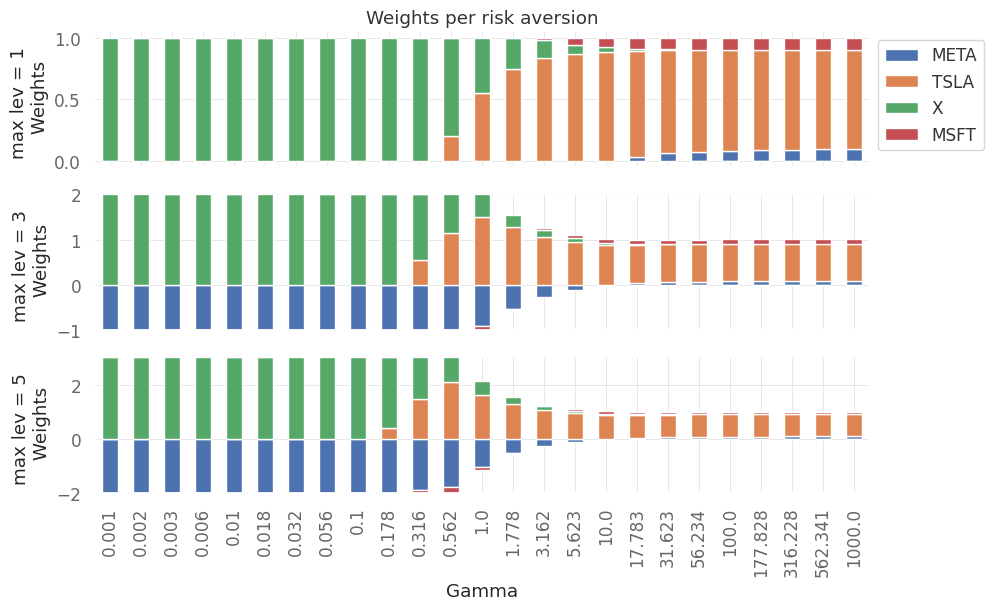

In [19]:
# plot the allocation for different allocation for different leverage and gamma

fig,axes = plt.subplots(len(lev_range),1,sharex=True)

for axi in range(len(axes)):

    weights_df = pd.DataFrame(portfolio_weights[axi], index=np.round(gamma_range,3),columns=stock_symbols)

    weights_df.plot(kind='bar',ax=axes[axi],stacked=True,xlabel="Gamma",ylabel=f"max lev = {lev_range[axi]} \n Weights",legend=None)

axes[0].legend(bbox_to_anchor=(1, 1))
axes[0].set_title("Weights per risk aversion")

plt.show()

we note that with an increase in risk aversion, all cases converge to a similar allocation for all levels of the leverage.

Traditional optimization methods depend on inverting covariance matrix. They are also unstable. More correlated assets lead to need of more diversification and which leads to more errors in calculation of portfolio weights.

## Hierarchical Risk Parity

Hierarchical Risk Parity (HRP) is a portfolio optimization technique that aims to allocate assets in a way that maximizes diversification and minimizes risk. It was introduced by Marcos Lopez de Prado. HRP differs from traditional mean-variance optimization by focusing on the hierarchical structure of the covariance matrix of asset returns.

Here's a brief explanation of the key steps involved in HRP:

1. **Dendrogram Construction:** HRP begins by constructing a dendrogram (tree diagram) that represents the hierarchical clustering of assets based on their pairwise correlation or covariance. This hierarchical structure captures the relationships between different assets.

2. **Recursive Bisection:** The dendrogram is then recursively bisected to form clusters of assets at different levels of the hierarchy. The idea is to group together assets that are more closely related in terms of risk and return characteristics.

3. **Inverse Variance Weighting:** Within each cluster, HRP assigns weights to assets based on their inverse variance (or equivalently, inverse risk). Assets with lower risk contribute more to the portfolio within a given cluster.

4. **Allocation at Each Level:** The process is repeated at each level of the hierarchy, recursively assigning weights to the clusters based on inverse variance. This hierarchical approach allows for a more nuanced allocation, capturing both global and local diversification benefits.

5. **Final Portfolio Construction:** The final portfolio is constructed by combining the weighted clusters from the lowest level of the hierarchy to the top.

HRP is particularly useful when dealing with a large number of assets, as it efficiently captures the diversification benefits inherent in the hierarchical structure of the covariance matrix. It can be more robust in the face of estimation errors compared to traditional mean-variance optimization.



In [1]:
import yfinance as yf
import pandas_datareader.data as pdr
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import quantstats as qs

yf.pdr_override()
from pypfopt.expected_returns import returns_from_prices
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting


In [16]:
# Define a list of stock symbols

stocks = {'Apple Inc.': 'AAPL',
'Microsoft Corporation': 'MSFT',
'Amazon.com Inc.': 'AMZN',
'Alphabet Inc.': 'GOOGL', 
'Meta Platforms, Inc.': 'META',
'Tesla, Inc.': 'TSLA',
'Johnson & Johnson': 'JNJ',
'JPMorgan Chase & Co.': 'JPM',
'Visa Inc.': 'V',
'Procter & Gamble Co.': 'PG',
'NVIDIA Corporation': 'NVDA',
'Mastercard Incorporated': 'MA',
'The Walt Disney Company': 'DIS',
'Salesforce.com Inc.': 'CRM'

}

stock_symbols = list(stocks.values())

# start date
start_date = '2018-01-01'
# end date
end_date = '2023-01-01'

stock_data = pdr.get_data_yahoo(stock_symbols,start_date,end_date)['Adj Close']

# returns
returns_df = returns_from_prices(stock_data)

[*********************100%%**********************]  14 of 14 completed


In [17]:
# Optimize using Hierarchical Risk Parity
hrp = HRPOpt(returns=returns_df)
hrp.optimize()

# get weights
weights = hrp.clean_weights()

print(weights)

OrderedDict([('AAPL', 0.05942), ('AMZN', 0.04517), ('CRM', 0.06996), ('DIS', 0.0784), ('GOOGL', 0.06652), ('JNJ', 0.16991), ('JPM', 0.08137), ('MA', 0.05232), ('META', 0.03086), ('MSFT', 0.06809), ('NVDA', 0.02474), ('PG', 0.15484), ('TSLA', 0.03146), ('V', 0.06692)])


In [18]:
# get portfolio performance
hrp.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 16.1%
Annual volatility: 22.4%
Sharpe Ratio: 0.72


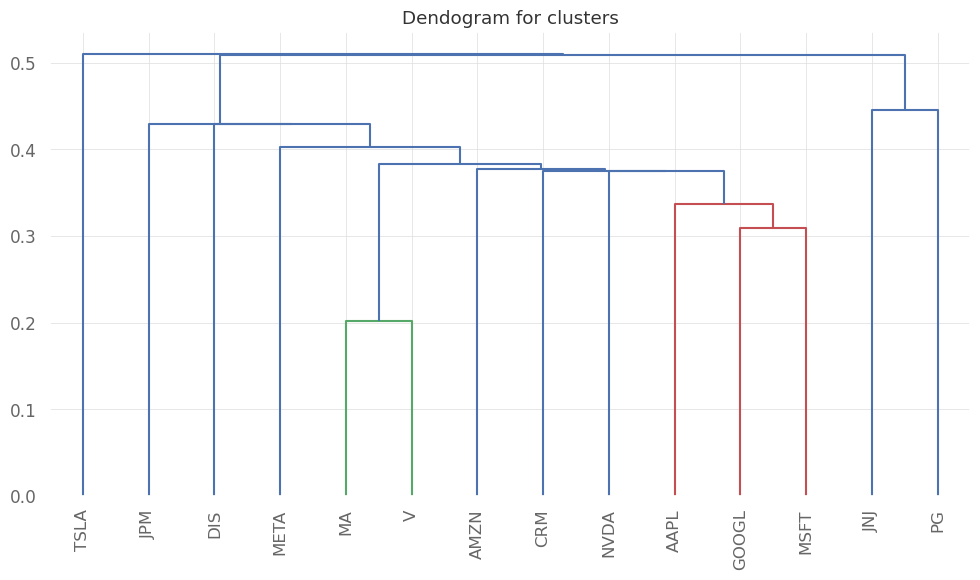

In [19]:
# plot the heirarchical clustering

fig,ax = plt.subplots()

ax.set_title("Dendogram for clusters")

plotting.plot_dendrogram(hrp, color_threshold=0, ax=ax, above_threshold_color='grey')

plt.show()

We see that similar companies are clustered together (eg. Visa and Mastercard or GOOGLE, Microsoft and Apple). So in order to diversify, we can choose companies belonging to different clusters. 

We can also find the allocation for each company for a total amount of money we wish to invest.

In [23]:
# get current prices and allocate 100,000 USD
latest_prices = get_latest_prices(stock_data)

# find allocation based on weights using hrp
allocation_finder = DiscreteAllocation(weights,
        latest_prices,
        total_portfolio_value=100000)

# get portolio
allocation, leftover = allocation_finder.lp_portfolio()


for stock in stocks.keys():
        if stocks[stock] in allocation.keys():
                print(f"{stock}: {allocation[stocks[stock]]}")

print(f"Leftover: {leftover}")

Apple Inc.: 46
Microsoft Corporation: 29
Amazon.com Inc.: 54
Alphabet Inc.: 75
Meta Platforms, Inc.: 26
Tesla, Inc.: 26
Johnson & Johnson: 99
JPMorgan Chase & Co.: 62
Visa Inc.: 32
Procter & Gamble Co.: 105
NVIDIA Corporation: 17
Mastercard Incorporated: 15
The Walt Disney Company: 90
Salesforce.com Inc.: 53
Leftover: 1.369749858728028


### Efficient Forntier using PyPortfolioOpt

Traditional sample covariance matrices can be noisy, especially when the number of assets is small relative to the number of observations. 
We can use Ledoit-Wolf shrinkage estimate of the covariance matrix. 
The idea is to find a compromise between the sample covariance matrix and a target matrix that assumes a certain structure for the true covariance matrix.
The target matrix is typically chosen to be a multiple of the identity matrix.


/home/ankitsingh/miniconda3/envs/DS/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


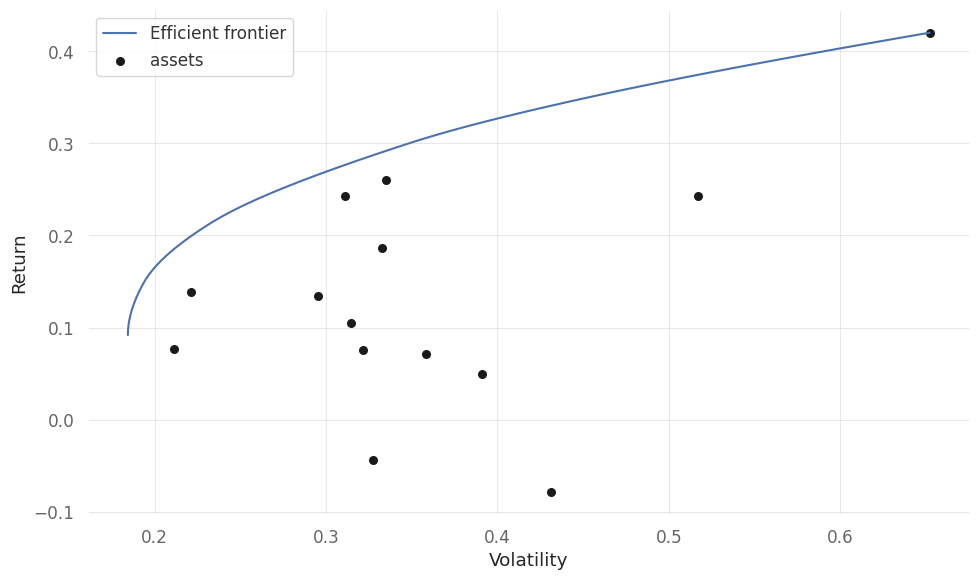

In [27]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier


# get mean and variance of returns
mu = mean_historical_return(stock_data, frequency=252)
covariance_matrix = CovarianceShrinkage(stock_data).ledoit_wolf()

# calculate the efficient frontier
EF = EfficientFrontier(mu, covariance_matrix)
# plot the EF
fig,ax = plt.subplots(1,1)

plot_efficient_frontier(EF, ax=ax, show_assets=True)

plt.show()

In [35]:
# get weights for highest sharpe ratio
EF = EfficientFrontier(mu, covariance_matrix)
weights_ms = EF.max_sharpe()

# get weights for minimum volatility
EF = EfficientFrontier(mu, covariance_matrix)
weights_mv = EF.min_volatility()

# print weights
print("At maximum sharpe ratio\n")
for stock in stocks.keys():
        if stocks[stock] in weights_ms.keys():
                print(f"{stock}: {weights_ms[stocks[stock]]}")

print("\nAt minimum volatility\n")
for stock in stocks.keys():
        if stocks[stock] in weights_mv.keys():
                print(f"{stock}: {weights_mv[stocks[stock]]}")

At maximum sharpe ratio

Apple Inc.: 0.245191828703573
Microsoft Corporation: 0.223290432799307
Amazon.com Inc.: 0.0
Alphabet Inc.: 0.0
Meta Platforms, Inc.: 0.0
Tesla, Inc.: 0.1619657168958174
Johnson & Johnson: 0.0
JPMorgan Chase & Co.: 0.0
Visa Inc.: 0.0
Procter & Gamble Co.: 0.3695520216013028
NVIDIA Corporation: 0.0
Mastercard Incorporated: 0.0
The Walt Disney Company: 0.0
Salesforce.com Inc.: 0.0

At minimum volatility

Apple Inc.: 0.0
Microsoft Corporation: 0.0
Amazon.com Inc.: 0.0959515427915488
Alphabet Inc.: 0.0041594590053027
Meta Platforms, Inc.: 0.0
Tesla, Inc.: 0.0054829509292488
Johnson & Johnson: 0.4440479006669384
JPMorgan Chase & Co.: 0.0288517492601816
Visa Inc.: 0.0
Procter & Gamble Co.: 0.3507875353775004
NVIDIA Corporation: 0.0
Mastercard Incorporated: 0.0
The Walt Disney Company: 0.0707188619692793
Salesforce.com Inc.: 0.0
